# Analyzing Total Covid Scams by State

Data can be found on the Federal Trade Commission Website:  https://www.ftc.gov/enforcement/data-visualizations/explore-data

[SGMAP Procedure documentation](https://go.documentation.sas.com/?docsetId=grmapref&docsetTarget=n18zwxj3couxmgn161trks2usk2v.htm&docsetVersion=9.4_01&locale=en)

#### Table of Contents:
1. [Setup](#1)
2. [Access Data](#2)
3. [Data Exploration](#3)
4. [Data Preparation](#4)
5. [Data Visualizations](#5)

#### [Final Visualization](#final)

## <a id='1'>1. Setup</a> 

In [1]:
****************************;
* Set Paths and Options    *;
****************************;

* Enter path*;
%let rc = %sysfunc(filename(fr,.));
%let curdir = %sysfunc(pathname(&fr));
%let rc = %sysfunc(filename(fr));

%let loc=&curdir;

%let filename=Title_State_Full_Data_data.csv;

* Variable names follow SAS naming rules *;
options validvarname=v7;

SAS Connection established. Subprocess id is 16544


9                                                          The SAS System                             14:19 Thursday, April 28, 2022

44         ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
44       ! ods graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1
45         
46         ****************************;
47         * Set Paths and Options    *;
48         ****************************;
49         
50         * Enter path*;
51         %let rc = %sysfunc(filename(fr,.));
52         %let curdir = %sysfunc(pathname(&fr));
53         %let rc = %sysfunc(filename(fr));
54         
55         %let loc=&curdir;
56         
57         %let filename=Title_State_Full_Data_data.csv;
58         
59         * Variable names follow SAS naming rules *;
60         options validvarname=v7;
61         
62         
63         ods html5 (id=saspy_

## <a id='2'>2. Access Data</a>
Import the **Title_State_Full_Data** csv file.

Log dqstring= note. See ticket: https://support.sas.com/kb/66/835.html

In [ ]:
* Change encoding to avoid warning *;
filename scams "&loc./&fileName" encoding="utf-8";

* Import CSV file *;
proc import datafile=scams
            out=covidScamsRaw
            dbms=csv
            replace;
    guessingrows=max;
run;

In [3]:
* Print the first 20 rows of the raw data *;

proc print data=covidScamsRaw(obs=20);
run;

Obs,Fraud,Consumer_State_Name_Cleansed,Blank,DC_Only,Fraud_Only,IDT_Only,Parameter_DWM,Product_Product_Code_Desc,Tooltip_lt_100_text,__Reports_by_Category_Overall_PS,__Reports_by_Category_Overall_St,__reporting_loss,F1,Median_Losses_by_Category_Overal,VAR15,Number_of_Records,Reporting_a_Loss_State,State_Total_Reports,Total_Losses_by_Category_Overall,VAR20
1,Do Not Call,Alabama,,False,False,False,By Day,Imposters,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",18,61,.,0,.,.,1,.,1509,0,0
2,Do Not Call,Alabama,,False,False,False,By Day,Dropped call or no message,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",1,61,.,1,.,.,1,.,1509,0,0
3,Do Not Call,Alabama,,False,False,False,By Day,"Energy, solar & utilities","For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",2,61,.,2,.,.,1,.,1509,0,0
4,Do Not Call,Alabama,,False,False,False,By Day,Medical & prescriptions,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",2,61,.,3,.,.,1,.,1509,0,0
5,Do Not Call,Alabama,,False,False,False,By Day,No Subject Provided,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",1,61,.,4,.,.,1,.,1509,0,0
6,Do Not Call,Alabama,,False,False,False,By Day,Other,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",20,61,.,5,.,.,1,.,1509,0,0
7,Do Not Call,Alabama,,False,False,False,By Day,Reducing debt,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",7,61,.,6,.,.,1,.,1509,0,0
8,Do Not Call,Alabama,,False,False,False,By Day,Vacation & timeshares,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",2,61,.,7,.,.,1,.,1509,0,0
9,Do Not Call,Alabama,,False,False,False,By Day,Warranties & protection plans,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",8,61,.,8,.,.,1,.,1509,0,0
10,Do Not Call,Alaska,,False,False,False,By Day,Imposters,"For states with fewer than 100 reports, the Top Reports graphic combines Fraud and Other categories.",3,5,.,9,.,.,1,.,184,0,0


## <a id='3'>3. Data Exploration</a>

In [4]:
* View column names, label names, and data type *;
ods select Position;

proc contents data=covidScamsRaw varnum;
run;

Total Rows: 4907
Total Columns: 20

## <a id='4'>4. Data Preparation</a>

### a. Sort the data by state and keep necessary columns. Only keep
  - the state name (Consumer_State_Name_Cleansed)
  - total number of fraud cases by that state (State_Total_Reports) *;

In [5]:
proc sort data=covidScamsRaw(keep=Consumer_State_Name_Cleansed State_Total_Reports)
          out=covidScamsSort 
          nodupkey;
    by Consumer_State_Name_Cleansed;
run;


17                                                         The SAS System                             14:19 Thursday, April 28, 2022

189        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
189      ! ods graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1
190        
191        proc sort data=covidScamsRaw(keep=Consumer_State_Name_Cleansed State_Total_Reports)
192                  out=covidScamsSort
193                  nodupkey;
194            by Consumer_State_Name_Cleansed;
195        run;

NOTE: There were 4907 observations read from the data set WORK.COVIDSCAMSRAW.
NOTE: 4855 observations with duplicate key values were deleted.
NOTE: The data set WORK.COVIDSCAMSSORT has 52 observations and 2 variables.
NOTE: PROCEDURE SORT used (Total process time):
      real time           0.01 seconds
      cpu time            0.01 seconds
      

196        
197        
198        ods h

### b. Rename the columns

In [6]:
data covidScams;
    set covidScamsSort;
    rename Consumer_State_Name_Cleansed=State
           State_Total_Reports=TotalReports;
run;


19                                                         The SAS System                             14:19 Thursday, April 28, 2022

203        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
203      ! ods graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1
204        
205        data covidScams;
206            set covidScamsSort;
207            rename Consumer_State_Name_Cleansed=State
208                   State_Total_Reports=TotalReports;
209        run;

NOTE: There were 52 observations read from the data set WORK.COVIDSCAMSSORT.
NOTE: The data set WORK.COVIDSCAMS has 52 observations and 2 variables.
NOTE: DATA statement used (Total process time):
      real time           0.00 seconds
      cpu time            0.00 seconds
      

210        
211        
212        ods html5 (id=saspy_internal) close;ods listing;
213        

20                                                

### c. Obtain the geographic coordinates for state using the mapsgfk.us_states_attr
***3 Steps:**
1. Preview the lookup tables
2. Create a view with State abbreviations
3. Create a table with the geographic coordinates called covidScamsFinal 
 

In [7]:
* 1. Preview the lookup tables *;

* State abbreviation table *;
proc print data=mapsgfk.us_states_attr (obs=5) noobs;
    var idName Statecode;
run;

* State center geographic coordinates table *;
proc print data=mapsgfk.uscenter_all (obs=5) noobs;
    var Lat Long StateCode;
run;

In [8]:
* 2. Join the lookup table to obtain State abbreviations *;
proc sql;
create table CovidScamsLookup as
select c.*, 
       ifc(us.StateCode="","PR",us.StateCode) as StateCode /* Puerto Rico is not in the lookup table. Will return missing. Condition will return PR for missing*/
    from covidScams as c left join
         mapsgfk.us_states_attr as us
    on c.State = us.idName;
quit;

* Preview the new table *;
proc print data=CovidScamsLookup (obs=5) noobs;
run;

State,TotalReports,StateCode
Alabama,1509,AL
Alaska,184,AK
Arizona,3080,AZ
Arkansas,826,AR
California,17692,CA


In [10]:
* 3. Create the final table that contains the center geographic coordinates for each State *;
proc sql;
create table covidScamsFinal as
select v.State, v.StateCode, 
       max(TotalReports) as TotalReports, 
       min(c.Lat) as Lat, min(c.Long) as Long
    from CovidScamsLookup as v left join
         mapsgfk.uscenter_all as c
    on v.StateCode = c.StateCode
    group by v.State, v.StateCode;
quit;

* Preview the table with geographic coordinates *;
proc print data=covidScamsFinal (obs=5) noobs;
run;

State,StateCode,TotalReports,Lat,Long
Alabama,AL,1509,32.6157,-86.733
Alaska,AK,184,63.0995,-151.989
Arizona,AZ,3080,34.1677,-111.661
Arkansas,AR,826,34.7518,-92.496
California,CA,17692,37.2710,-119.993


## <a id='5'>5. Data Visualization</a>

### First Attempt:


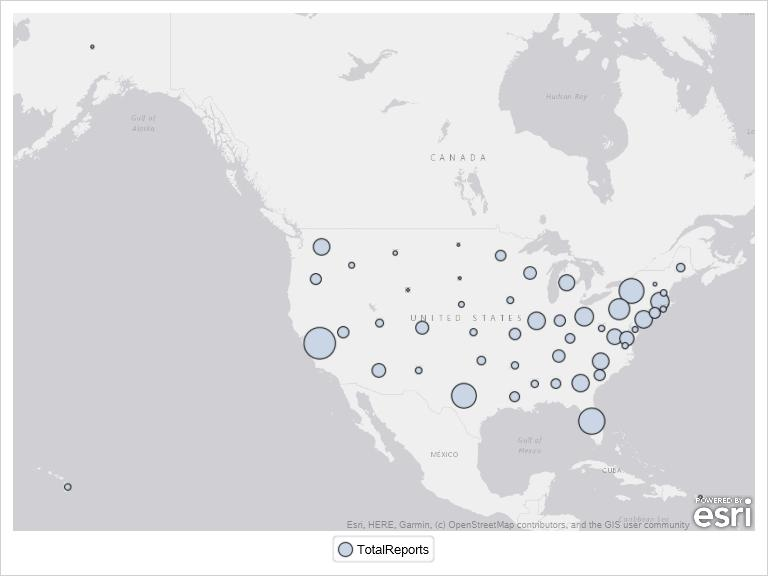

In [12]:
* Default *;

ods listing gpath="&loc/images";
ods graphics / width=8in imagename="covidscamsMap_firstattempt" imagefmt=jpeg;

proc sgmap plotdata=covidScamsFinal;
    esrimap url="http://services.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base";
    bubble x=Long y=Lat size=TotalReports / 
                 bradiusmax=13pt bradiusmin=1pt;  * <---Set size of bubbles *;
run;
title;

ods graphics / reset;

### Second Attempt:
Recreate the data to show the top 5 states with covid scams.

In [13]:
* Sort the table by descending TotalReports *;
proc sort data=covidScamsFinal
          out=covidScamsTop5Sorted;
    by descending TotalReports;
run;

* Create a new table that places a 'yes' indicator if the state is in the top 5 *;
* New table also creates a string for the top 5 states that includes the total number of cases *;
data CovidScamsTop5;
    set covidScamsTop5Sorted;
    if _n_ <= 5 then do;
        Top5 = "Yes";
        Top5Name=catx(" ",State,put(TotalReports,comma16.));
    end;
    else do;
        Top5 = "No";
        Top5Name="";
    end;
run;

* Preview the new table *;
proc print data=CovidScamsTop5 (obs=10) noobs;
run;

State,StateCode,TotalReports,Lat,Long,Top5,Top5Name
California,CA,17692,37.2710,-119.993,Yes,"California 17,692"
Florida,FL,12008,28.0584,-81.686,Yes,"Florida 12,008"
New York,NY,10794,42.8994,-76.090,Yes,"New York 10,794"
Texas,TX,10696,31.1694,-99.684,Yes,"Texas 10,696"
Pennsylvania,PA,7657,40.9947,-77.822,Yes,"Pennsylvania 7,657"
Ohio,OH,5908,40.1912,-82.742,No,
Massachusetts,MA,5768,41.8000,-72.094,No,
Illinois,IL,5232,39.7409,-89.450,No,
New Jersey,NJ,5206,39.9000,-74.377,No,
Georgia,GA,5074,32.6788,-83.253,No,



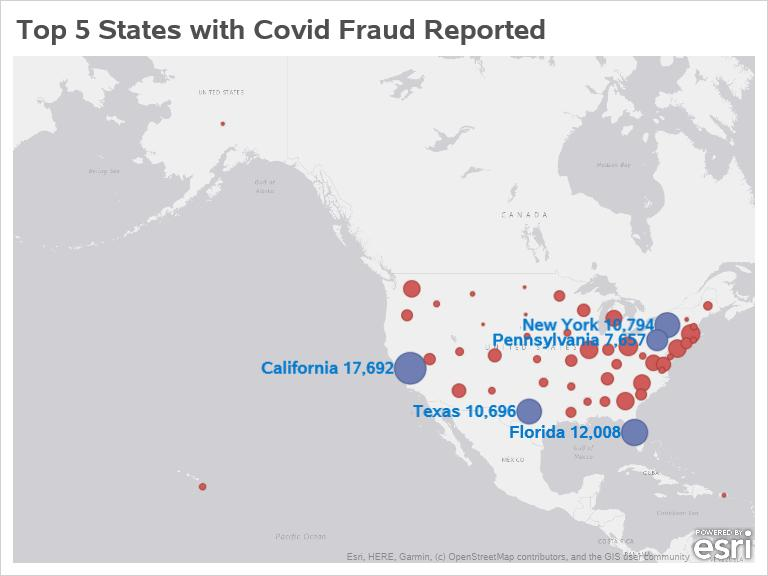

In [15]:
ods listing gpath="&loc/images";
ods graphics / width=8in imagename="covidscamsMap_second" imagefmt=jpeg;

title height=20pt justify=left color=charcoal "Top 5 States with Covid Fraud Reported";
proc sgmap plotdata=CovidScamsTop5;
    esrimap url="http://services.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base";
    bubble x=Long y=Lat size=TotalReports / 
                 bradiusmax=13pt bradiusmin=1pt
                 group=Top5
                 datalabel=Top5Name
                 datalabelpos=left
                 datalabelattrs=(size=12pt weight=bold color=cx0379cd);
    gradlegend;
run;
title;

ods graphics / reset;

# <a id='final'>Final Visualization</a>

Adjust the colors of the visual so the top 5 tops are a brighter color, and the other states are gray by using a user defined style template.

**Create new style template**

In [16]:
* Location to read and write style templates *;
ods path work.mytemps (update)
         sashelp.tmplmst (read);

* Create a style template to apply in the SGMAP procedure *;
proc template;
    define style styles.myStyle;
    parent=styles.htmlblue;
***************** Modify Group Graph Colors *****************;
    class GraphColors /  
       /*FILL COLORS*/
           'gdata1' = cx0379cd
           'gdata2' = cxa6a4a4;
***************** Modify Graph Outlines *****************;
    class GraphOutlines /
            LineThickness=0px;
    end;
run;


39                                                         The SAS System                             14:19 Thursday, April 28, 2022

434        ods listing close;ods html5 (id=saspy_internal) file=_tomods1 options(bitmap_mode='inline') device=svg style=HTMLBlue;
434      ! ods graphics on / outputfmt=png;
NOTE: Writing HTML5(SASPY_INTERNAL) Body file: _TOMODS1
435        
436        * Location to read and write style templates *;
437        ods path work.mytemps (update)
438                 sashelp.tmplmst (read);
439        
440        * Create a style template to apply in the SGMAP procedure *;
441        proc template;
442            define style styles.myStyle;
443            parent=styles.htmlblue;
444        ***************** Modify Group Graph Colors *****************;
445            class GraphColors /
446               /*FILL COLORS*/
447                   'gdata1' = cx0379cd
448                   'gdata2' = cxa6a4a4;
449        ***************** Modify Graph Outlines ******

**Apply a style to finalize visualization**


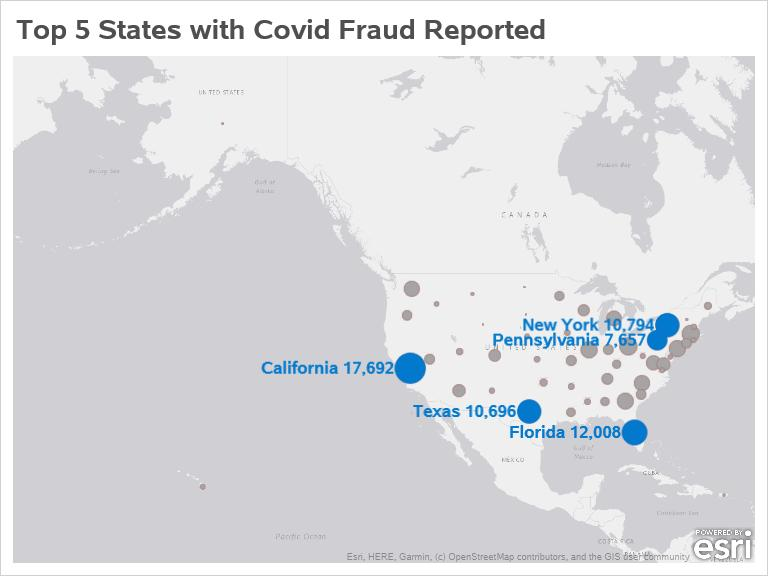

In [17]:
* Apply the style to the HTML5 default destination in Jupyter notebook *;
ods html5 (id=saspy_internal) style=myStyle;


ods listing gpath="&loc/images";
ods graphics / width=8in imagename="covidscamsMap_final" imagefmt=jpeg;

title height=20pt justify=left color=charcoal "Top 5 States with Covid Fraud Reported";
proc sgmap plotdata=CovidScamsTop5;
    esrimap url="http://services.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base";
    bubble x=Long y=Lat size=TotalReports / 
                 bradiusmax=13pt bradiusmin=1pt
                 group=Top5
                 datalabel=Top5Name
                 datalabelpos=left
                 datalabelattrs=(size=12pt weight=bold color=cx0379cd);
    gradlegend;
run;
title;

ods html5 close;

ods graphics / reset;